<a href="https://colab.research.google.com/github/NLinh-Tran/Lending-Club-Analysis/blob/main/Loan_Charge_Off_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
wordsforthewise_lending_club_path = kagglehub.dataset_download('wordsforthewise/lending-club')

print('Data source import complete.')

Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


# **INSTALL PYSPARK**

In [3]:
!pip install PySpark

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import logging
import sys
import os
import plotly.express as px

print('Import Libraries')

Import Libraries


In [5]:
spark = SparkSession.builder                                        \
                    .appName("LendingClubAnalysis")                 \
                    .config("spark.ui.showConsoleProgress","false") \
                    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

In [6]:
accepted_df = spark.read.option("header", True)                                             \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz")

rejected_df = spark.read.option("header", True)                                            \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz")

# Build dataset

In [7]:
df = accepted_df.filter(col("loan_status").isin(["Fully Paid",
                                                 "Default",
                                                 "Charged Off",
                                                 "Does not meet the credit policy. Status:Charged Off"])) \
                .filter((col('dti') >= 0) & (col('dti') <= 100)) \
                .withColumn("CO_flag", when(col("loan_status").isin(["Default",
                                                                     "Charged Off",
                                                                     "Does not meet the credit policy. Status:Charged Off"]), 1)
                .otherwise(0)) \
                .withColumn("issue_d", to_date(col("issue_d"), "MMM-yyyy")) \
                .withColumn("earliest_cr_line", to_date(col("earliest_cr_line"), "MMM-yyyy")) \
                .withColumn("credit_history_months",round(months_between(col("issue_d"), col("earliest_cr_line"))).cast("int")) \
                .withColumn('emp_length_years',
                                      when(col('emp_length') == '< 1 year', 0)
                                      .when(col('emp_length') == '1 year', 1)
                                      .when(col('emp_length') == '2 years', 2)
                                      .when(col('emp_length') == '3 years', 3)
                                      .when(col('emp_length') == '4 years', 4)
                                      .when(col('emp_length') == '5 years', 5)
                                      .when(col('emp_length') == '6 years', 6)
                                      .when(col('emp_length') == '7 years', 7)
                                      .when(col('emp_length') == '8 years', 8)
                                      .when(col('emp_length') == '9 years', 9)
                                      .when(col('emp_length') == '10+ years', 10)
                                      .when(col('emp_length').isNull(), None)
                                      .otherwise(None))

In [ ]:
columns = df.select("CO_flag", "loan_amnt", "term", "int_rate", "installment", "grade", "sub_grade",
          "emp_length", "home_ownership", "annual_inc", "verification_status", "application_type",
          "issue_d", "credit_history_months",
          "addr_state",
          "dti", "annual_inc_joint", "dti_joint",
          "fico_range_low", "fico_range_high",
          "open_acc", "total_acc", "earliest_cr_line",
          "revol_bal", "revol_util",
          "inq_last_6mths", "delinq_2yrs", "collections_12_mths_ex_med", "acc_now_delinq",
          "pub_rec", "pub_rec_bankruptcies")

df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in columns.columns
]).show()

+-------+---------+----+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------------+-------+---------------------+----------+---+----------------+---------+--------------+---------------+--------+---------+----------------+---------+----------+--------------+-----------+--------------------------+--------------+-------+--------------------+
|CO_flag|loan_amnt|term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|application_type|issue_d|credit_history_months|addr_state|dti|annual_inc_joint|dti_joint|fico_range_low|fico_range_high|open_acc|total_acc|earliest_cr_line|revol_bal|revol_util|inq_last_6mths|delinq_2yrs|collections_12_mths_ex_med|acc_now_delinq|pub_rec|pub_rec_bankruptcies|
+-------+---------+----+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------------+-------+---------------------+----------+---+----------------+---------+-----

In [ ]:
df.groupBy('acc_now_delinq').count().show()

+--------------+-------+
|acc_now_delinq|  count|
+--------------+-------+
|           0.0|1338861|
|          NULL|      3|
|           1.0|   5975|
|           4.0|     10|
|          14.0|      1|
|           3.0|     42|
|           2.0|    306|
|           6.0|      1|
|           5.0|      3|
+--------------+-------+



In [ ]:
df.select('loan_amnt').summary().toPandas()

,summary,loan_amnt
0,count,1345202
1,mean,14414.153710743814
2,stddev,8714.515204474957
3,min,500.0
4,25%,8000.0
5,50%,12000.0
6,75%,20000.0
7,max,40000.0


In [ ]:
numeric_cols = [
    "loan_amnt", "int_rate", "installment", "annual_inc", "dti", "annual_inc_joint", "dti_joint",
    "fico_range_low", "fico_range_high", "open_acc", "total_acc", "revol_bal", "revol_util",
    "inq_last_6mths", "delinq_2yrs", "collections_12_mths_ex_med", "pub_rec", "pub_rec_bankruptcies"
]

quantiles = [0.01, 0.25, 0.5, 0.75, 0.95, 0.99]

for col_name in numeric_cols:
    print(f"Column: {col_name}")
    print(df.approxQuantile(col_name, quantiles, 0.01))
    print("------")

Column: loan_amnt
[500.0, 8000.0, 12000.0, 20000.0, 32000.0, 40000.0]
------
Column: int_rate
[5.31, 9.75, 12.69, 16.02, 21.99, 30.99]
------
Column: installment
[4.93, 247.29, 378.67, 577.44, 929.89, 1719.83]
------
Column: annual_inc
[430.0, 46000.0, 65000.0, 92000.0, 156000.0, 10999200.0]
------
Column: dti
[0.0, 11.78, 17.5, 23.85, 33.37, 100.0]
------
Column: annual_inc_joint
[11000.0, 80000.0, 105000.0, 140000.0, 205000.0, 1837000.0]
------
Column: dti_joint
[0.0, 13.27, 18.27, 23.83, 31.51, 69.49]
------
Column: fico_range_low
[615.0, 670.0, 690.0, 715.0, 760.0, 845.0]
------
Column: fico_range_high
[619.0, 674.0, 694.0, 719.0, 764.0, 850.0]
------
Column: open_acc
[0.0, 8.0, 11.0, 15.0, 22.0, 90.0]
------
Column: total_acc
[1.0, 16.0, 24.0, 32.0, 48.0, 176.0]
------
Column: revol_bal
[0.0, 5784.0, 10983.0, 19272.0, 42676.0, 2904836.0]
------
Column: revol_util
[0.0, 33.7, 52.2, 70.8, 90.1, 892.3]
------
Column: inq_last_6mths
[0.0, 0.0, 0.0, 1.0, 3.0, 33.0]
------
Column: delin

In [ ]:
import plotly.express as px

col_name= [
    "loan_amnt", "int_rate", "installment", "annual_inc", "dti", "annual_inc_joint", "dti_joint",
    "fico_range_low", "fico_range_high", "open_acc", "total_acc", "revol_bal", "revol_util",
    "inq_last_6mths", "delinq_2yrs", "collections_12_mths_ex_med", "pub_rec", "pub_rec_bankruptcies"]

def plot_histogram(df, col_name, bin_size=5000, max_value=1500000, log_y=False):
    # Compute histogram using PySpark RDD
    hist = df.select(col_name).rdd.flatMap(lambda x: x).histogram(list(range(0, max_value, bin_size)))

    bins = hist[0]
    counts = hist[1]
    mid_points = [(bins[i] + bins[i+1]) // 2 for i in range(len(bins)-1)]

    df_hist = pd.DataFrame({
        col_name: mid_points,
        "Count": counts
    })

    # Plot
    fig = px.bar(df_hist, x=col_name, y="Count",
                 title=f"Distribution of {col_name}",
                 height=400)

    fig.update_layout(
        xaxis_title='',
        yaxis_title='',
        template='simple_white',
        yaxis_type='log' if log_y else 'linear'
    )

    fig.show()

for col in col_name:
    print(f"Rendering: {col}")

    if col in ["annual_inc", "annual_inc_joint"]:
        plot_histogram(df, col, bin_size=10000, max_value=1000000, log_y=True)

    elif col in ["revol_bal"]:
        plot_histogram(df, col, bin_size=10000, max_value=500000, log_y=True)

    elif col in ["dti", "dti_joint", "revol_util"]:
        plot_histogram(df, col, bin_size=5, max_value=200, log_y=True)

    elif col in ["inq_last_6mths", "delinq_2yrs", "acc_now_delinq", "collections_12_mths_ex_med", "pub_rec", "pub_rec_bankruptcies"]:
        plot_histogram(df, col, bin_size=1, max_value=50, log_y=True)

    else:
        plot_histogram(df, col, bin_size=1000, max_value=100000, log_y=False)


Rendering: loan_amnt


Rendering: int_rate


Rendering: installment


Rendering: annual_inc


Rendering: dti


Rendering: annual_inc_joint


Rendering: dti_joint


Rendering: fico_range_low


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
import plotly.express as px
import builtins

col_name= [
    "loan_amnt", "int_rate", "installment", "annual_inc", "dti", "annual_inc_joint", "dti_joint",
    "fico_range_low", "fico_range_high", "open_acc", "total_acc", "revol_bal", "revol_util",
    "inq_last_6mths", "delinq_2yrs", "collections_12_mths_ex_med", "pub_rec", "pub_rec_bankruptcies"]

def plot_histogram(df, col_name, bin_size=5000, max_value=1500000, log_y=False):
    # Compute histogram using PySpark RDD
    # Ensure at least two bins
    max_value = int(max_value)
    bin_size = int(bin_size)
    bucket_end = builtins.max(max_value, bin_size * 2)
    buckets = list(range(0, bucket_end + bin_size, bin_size))  # add one more to ensure full coverage

    # Then calculate histogram safely
    hist = df.select(col_name).rdd.flatMap(lambda x: x).histogram(buckets)

    bins = hist[0]
    counts = hist[1]
    mid_points = [(bins[i] + bins[i+1]) // 2 for i in range(len(bins)-1)]

    df_hist = pd.DataFrame({
        col_name: mid_points,
        "Count": counts
    })

    # Plot
    fig = px.bar(df_hist, x=col_name, y="Count",
                 title=f"Distribution of {col_name}",
                 height=400)

    fig.update_layout(
        xaxis_title='',
        yaxis_title='',
        template='simple_white',
        yaxis_type='log' if log_y else 'linear'
    )

    fig.show()

for col in col_name:

    max_val = df.agg({col: "max"}).collect()[0][0]

    if col in ["annual_inc", "annual_inc_joint"]:
        plot_histogram(df, col, bin_size=10000, max_value=max_val, log_y=True)

    elif col in ["revol_bal"]:
        plot_histogram(df, col, bin_size=10000, max_value=max_val, log_y=True)

    elif col in ["dti", "dti_joint", "revol_util"]:
        plot_histogram(df, col, bin_size=5, max_value=max_val, log_y=True)

    elif col in ["inq_last_6mths", "delinq_2yrs", "acc_now_delinq", "collections_12_mths_ex_med", "pub_rec", "pub_rec_bankruptcies"]:
        plot_histogram(df, col, bin_size=1, max_value=max_val, log_y=True)

    else:
        plot_histogram(df, col, bin_size=1000, max_value=max_val, log_y=False)

In [ ]:
import math
import pandas as pd
import plotly.express as px
import builtins

# Step 1: Get the max interest rate (rounded up)
max_val = df.agg({"int_rate": "max"}).collect()[0][0]
max_val = math.ceil(max_val)
bin_size = 1

# Step 2: Create bucket edges
buckets = list(range(0, builtins.max(max_val, bin_size * 2) + bin_size, bin_size))

# Step 3: Compute histogram from RDD
hist = df.select("int_rate").rdd.flatMap(lambda x: x).histogram(buckets)

# Step 4: Create DataFrame for plotting
bins = hist[0]
counts = hist[1]
mid_points = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

df_hist = pd.DataFrame({
    "Interest Rate (%)": mid_points,
    "Count": counts
})

# Step 5: Plot
fig = px.bar(df_hist, x="Interest Rate (%)", y="Count",
             title="Distribution of Interest Rate",
             height=400,
             template='simple_white')

fig.update_layout(xaxis_title="", yaxis_title="")
fig.show()


In [ ]:
import math
import pandas as pd
import plotly.express as px
import builtins

max_val = df.agg({"installment": "max"}).collect()[0][0]
max_val = math.ceil(max_val)
bin_size = 25

# Step 2: Create bucket edges
buckets = list(range(0, builtins.max(max_val, bin_size * 2) + bin_size, bin_size))

# Step 3: Compute histogram from RDD
hist = df.select("installment").rdd.flatMap(lambda x: x).histogram(buckets)

# Step 4: Create DataFrame for plotting
bins = hist[0]
counts = hist[1]
mid_points = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

df_hist = pd.DataFrame({
    "Installment": mid_points,
    "Count": counts
})

# Step 5: Plot
fig = px.bar(df_hist, x="Installment", y="Count",
             title="Distribution of Installment",
             height=400,
             template='simple_white')

fig.update_layout(xaxis_title="", yaxis_title="")
fig.show()


In [ ]:
import math
import pandas as pd
import plotly.express as px
import builtins

max_val = df.agg({"fico_range_low": "max"}).collect()[0][0]
max_val = math.ceil(max_val)
bin_size = 5

# Step 2: Create bucket edges
buckets = list(range(0, builtins.max(max_val, bin_size * 2) + bin_size, bin_size))

# Step 3: Compute histogram from RDD
hist = df.select("fico_range_low").rdd.flatMap(lambda x: x).histogram(buckets)

# Step 4: Create DataFrame for plotting
bins = hist[0]
counts = hist[1]
mid_points = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

df_hist = pd.DataFrame({
    "fico_range_low": mid_points,
    "Count": counts
})

# Step 5: Plot
fig = px.bar(df_hist, x="fico_range_low", y="Count",
             title="Distribution of fico_range_low",
             height=400,
             template='simple_white')

fig.update_layout(xaxis_title="", yaxis_title="")
fig.show()


In [ ]:
import math
import pandas as pd
import plotly.express as px
import builtins

max_val = df.agg({"fico_range_high": "max"}).collect()[0][0]
max_val = math.ceil(max_val)
bin_size = 5

# Step 2: Create bucket edges
buckets = list(range(0, builtins.max(max_val, bin_size * 2) + bin_size, bin_size))

# Step 3: Compute histogram from RDD
hist = df.select("fico_range_high").rdd.flatMap(lambda x: x).histogram(buckets)

# Step 4: Create DataFrame for plotting
bins = hist[0]
counts = hist[1]
mid_points = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

df_hist = pd.DataFrame({
    "fico_range_high": mid_points,
    "Count": counts
})

# Step 5: Plot
fig = px.bar(df_hist, x="fico_range_high", y="Count",
             title="Distribution of fico_range_high",
             height=400,
             template='simple_white')

fig.update_layout(xaxis_title="", yaxis_title="")
fig.show()


In [ ]:
import math
import pandas as pd
import plotly.express as px
import builtins

max_val = df.agg({"total_acc": "max"}).collect()[0][0]
max_val = math.ceil(max_val)
bin_size = 1

# Step 2: Create bucket edges
buckets = list(range(0, builtins.max(max_val, bin_size * 2) + bin_size, bin_size))

# Step 3: Compute histogram from RDD
hist = df.select("total_acc").rdd.flatMap(lambda x: x).histogram(buckets)

# Step 4: Create DataFrame for plotting
bins = hist[0]
counts = hist[1]
mid_points = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

df_hist = pd.DataFrame({
    "total_acc": mid_points,
    "Count": counts
})

# Step 5: Plot
fig = px.bar(df_hist, x="total_acc", y="Count",
             title="Distribution of total_acc",
             height=400,
             template='simple_white')

fig.update_layout(xaxis_title="", yaxis_title="")
fig.show()


In [18]:
df.withColumn('revol_bal_to_income', col('revol_bal')/col('annual_inc')) \
  .orderBy(desc('revol_bal')) \
  .select('revol_bal', 'annual_inc', 'revol_bal_to_income', 'revol_util', 'fico_range_low', 'fico_range_high', 'application_type', 'dti',  'CO_flag') \
  .show(50)

+---------+----------+-------------------+----------+--------------+---------------+----------------+-----+-------+
|revol_bal|annual_inc|revol_bal_to_income|revol_util|fico_range_low|fico_range_high|application_type|  dti|CO_flag|
+---------+----------+-------------------+----------+--------------+---------------+----------------+-----+-------+
|2904836.0|  400000.0|            7.26209|      37.4|         740.0|          744.0|      Individual|24.83|      0|
|2568995.0| 1000000.0|           2.568995|      20.4|         725.0|          729.0|      Individual|12.54|      0|
|2560703.0|  999999.0| 2.5607055607055607|      16.3|         720.0|          724.0|      Individual| 13.3|      0|
|1746716.0|  400000.0|            4.36679|      38.6|         740.0|          744.0|      Individual| 32.8|      1|
|1743266.0|  400000.0|           4.358165|      29.5|         750.0|          754.0|      Individual|33.48|      0|
|1696796.0|  575000.0|  2.950949565217391|      33.0|         715.0|    

In [32]:
from pyspark.sql.functions import when, col, count, sum

# Step 1: Create ratio buckets
buckets = df.withColumn('revol_bal_to_income', round(col('revol_bal')/col('annual_inc'),2)) \
            .withColumn('revol_bal_to_income', when(col('revol_bal_to_income') > 10, 10).otherwise(col('revol_bal_to_income'))) \
            .withColumn("revol_to_inc_bucket",
                        when((col("revol_bal_to_income") >= 0)   & (col("revol_bal_to_income") < 0.5), "0–0.5")
                       .when((col("revol_bal_to_income") >= 0.5) & (col("revol_bal_to_income") < 1),   "0.5–1")
                       .when((col("revol_bal_to_income") >= 1)   & (col("revol_bal_to_income") < 2),   "1–2")
                       .when((col("revol_bal_to_income") >= 2)   & (col("revol_bal_to_income") < 3),   "2–3")
                       .when((col("revol_bal_to_income") >= 3)   & (col("revol_bal_to_income") < 5),   "3–5")
                       .when((col("revol_bal_to_income") >= 5)   & (col("revol_bal_to_income") <= 10),  "5–10")
)

# Step 2–3: Group by and calculate charge-off rate

total = buckets.count()

chargeoff_by_bucket = buckets.groupBy("revol_to_inc_bucket") \
    .agg(
        count("*").alias("loan_count"),
        sum("CO_flag").alias("num_chargeoffs")
    ) \
    .withColumn("chargeoff_rate_overall", round((col("num_chargeoffs") / total)*100, 2)) \
    .withColumn("chargeoff_rate_bucket", round((col("num_chargeoffs") / col('loan_count'))*100, 2)) \
    .orderBy("revol_to_inc_bucket") \
    .show()

# # Step 4: Convert to Pandas for plotting
# pdf = chargeoff_by_bucket.toPandas().sort_values("revol_to_inc_bucket")

# # Optional: format the order of buckets correctly
# bucket_order = ["0–0.5", "0.5–1", "1–2", "2–3", "3–5", "5–10", "10+"]
# pdf["revol_to_inc_bucket"] = pd.Categorical(pdf["revol_to_inc_bucket"], categories=bucket_order, ordered=True)
# pdf = pdf.sort_values("revol_to_inc_bucket")


+-------------------+----------+--------------+----------------------+---------------------+
|revol_to_inc_bucket|loan_count|num_chargeoffs|chargeoff_rate_overall|chargeoff_rate_bucket|
+-------------------+----------+--------------+----------------------+---------------------+
|              0.5–1|     85463|         19619|                  1.46|                22.96|
|              0–0.5|   1248409|        247460|                  18.4|                19.82|
|                1–2|      9603|          1768|                  0.13|                18.41|
|                2–3|      1295|           215|                  0.02|                 16.6|
|                3–5|       373|            77|                  0.01|                20.64|
|               5–10|        59|             7|                   0.0|                11.86|
+-------------------+----------+--------------+----------------------+---------------------+



In [ ]:
import math
import pandas as pd
import plotly.express as px
import builtins

max_val = df.agg({"open_acc": "max"}).collect()[0][0]
max_val = math.ceil(max_val)
bin_size = 1

# Step 2: Create bucket edges
buckets = list(range(0, builtins.max(max_val, bin_size * 2) + bin_size, bin_size))

# Step 3: Compute histogram from RDD
hist = df.select("open_acc").rdd.flatMap(lambda x: x).histogram(buckets)

# Step 4: Create DataFrame for plotting
bins = hist[0]
counts = hist[1]
mid_points = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

df_hist = pd.DataFrame({
    "open_acc": mid_points,
    "Count": counts
})

# Step 5: Plot
fig = px.bar(df_hist, x="open_acc", y="Count",
             title="Distribution of open_acc",
             height=400,
             template='simple_white')

fig.update_layout(xaxis_title="", yaxis_title="")
fig.show()


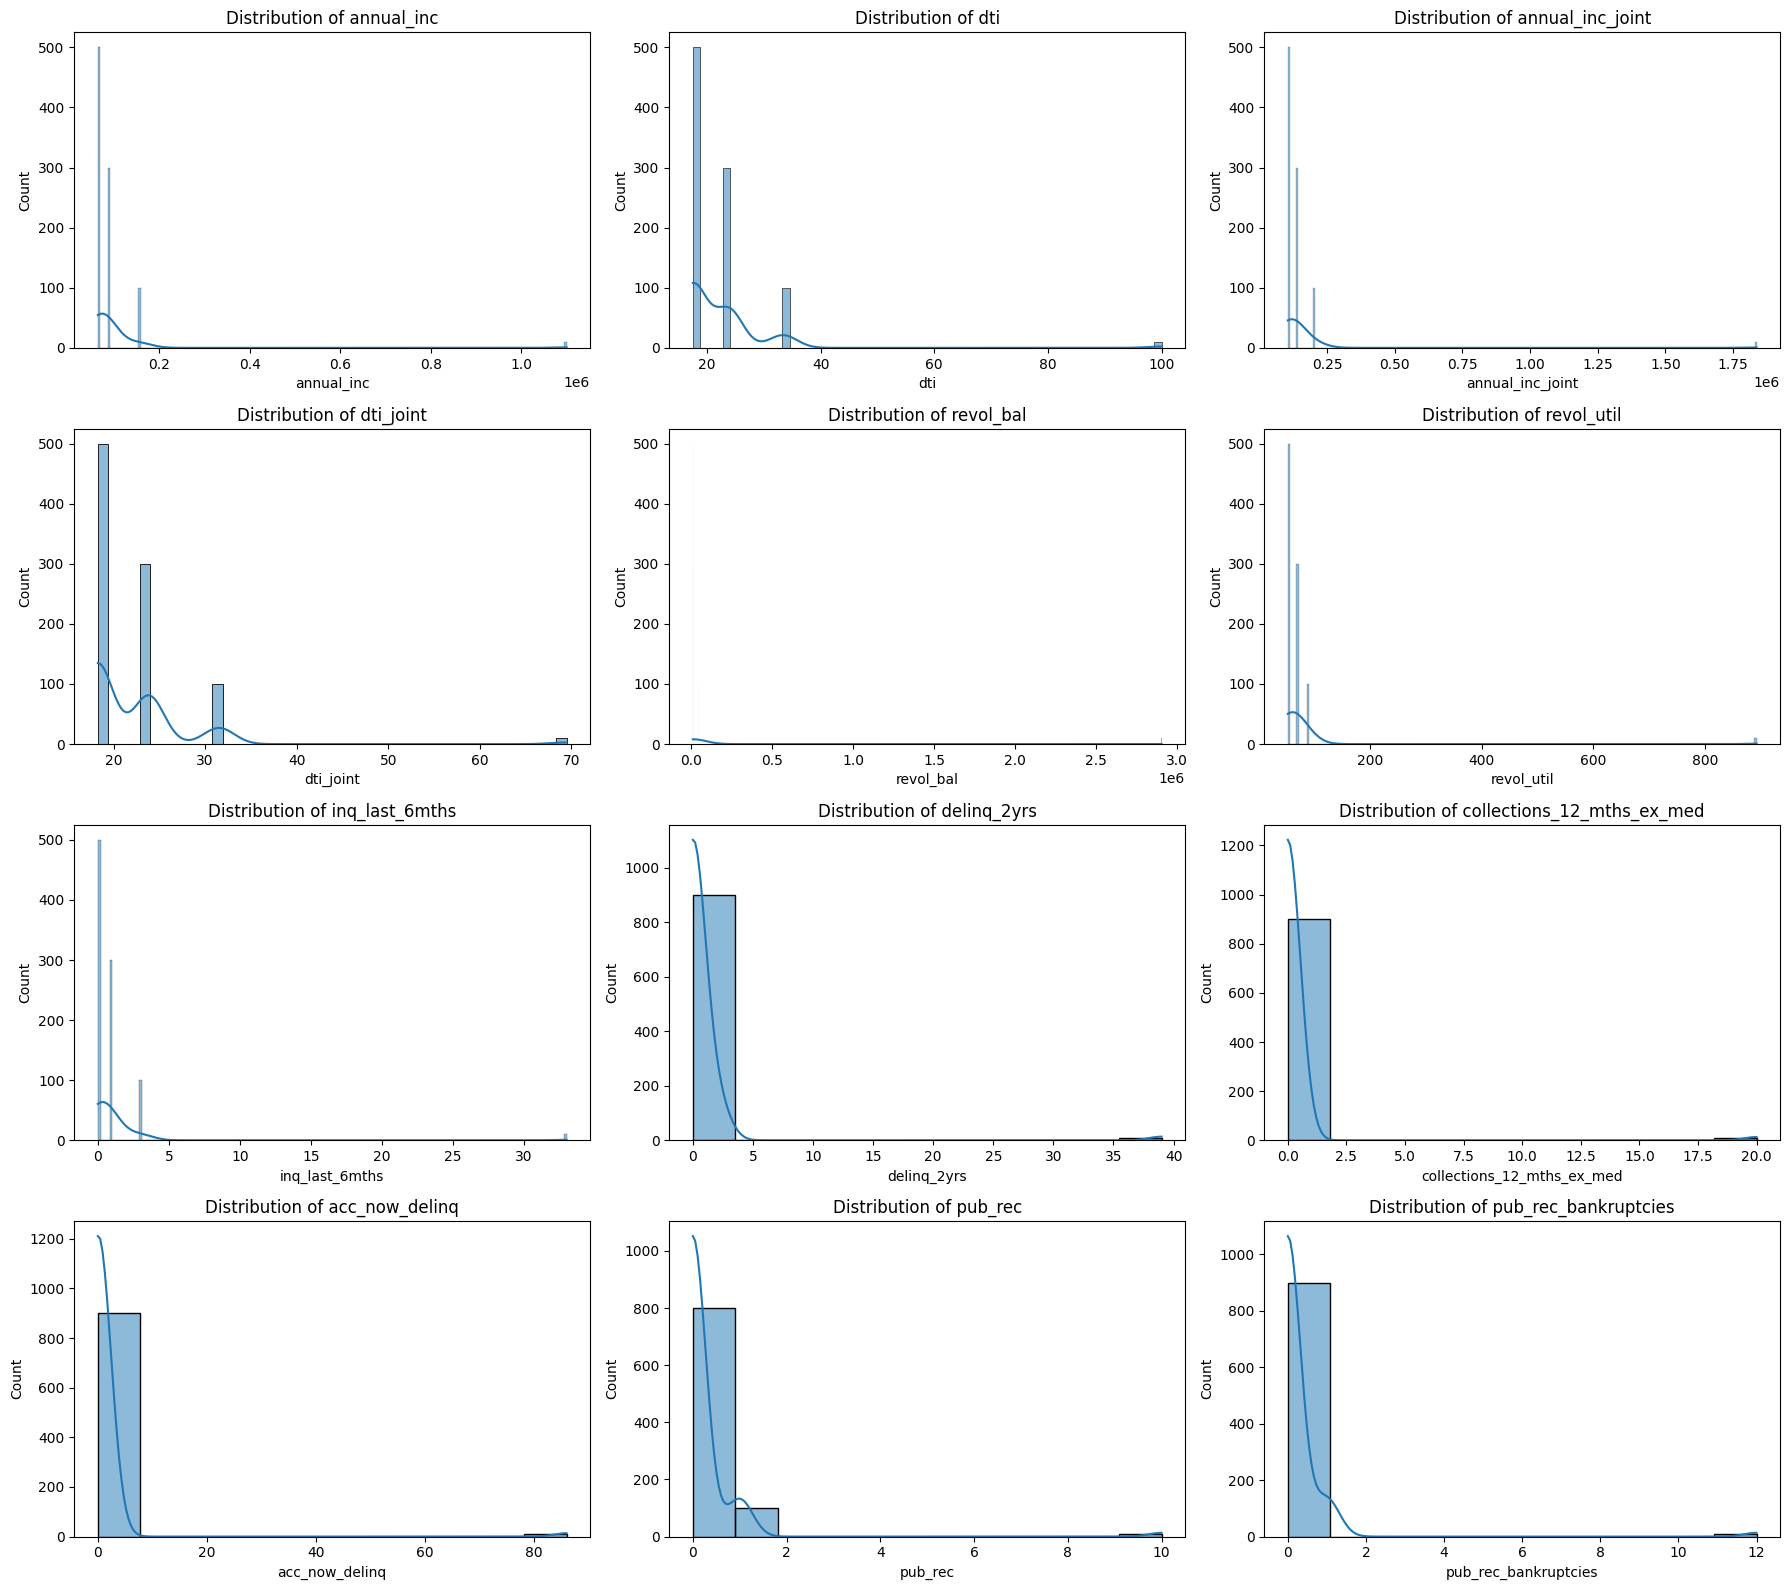

In [ ]:
# Re-import necessary libraries after kernel reset
import matplotlib.pyplot as plt
import seaborn as sns

# Re-define quantile summary manually since state was reset
quantile_summary = {
    "annual_inc": [430, 46000, 65000, 92000, 156000, 1099920],
    "dti": [0.0, 11.78, 17.5, 23.85, 33.37, 100.0],
    "annual_inc_joint": [11000, 80000, 105000, 140000, 205000, 1837000],
    "dti_joint": [0.0, 13.27, 18.27, 23.83, 31.51, 69.49],
    "revol_bal": [0.0, 5784.0, 10983.0, 19272.0, 42676.0, 2904836.0],
    "revol_util": [0.0, 33.7, 52.21, 70.8, 90.1, 892.3],
    "inq_last_6mths": [0.0, 0.0, 0.0, 1.0, 3.0, 33.0],
    "delinq_2yrs": [0.0, 0.0, 0.0, 0.0, 2.0, 39.0],
    "collections_12_mths_ex_med": [0.0, 0.0, 0.0, 0.0, 0.0, 20.0],
    "acc_now_delinq": [0.0, 0.0, 0.0, 0.0, 1.0, 86.0],
    "pub_rec": [0.0, 0.0, 0.0, 0.0, 1.0, 10.0],
    "pub_rec_bankruptcies": [0.0, 0.0, 0.0, 0.0, 1.0, 12.0]
}

# Plot histogram for each feature based on synthetic distribution for visual reference
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
axes = axes.flatten()

for i, (feature, quants) in enumerate(quantile_summary.items()):
    # Simulate a skewed distribution based on quantiles
    data = [quants[2]] * 500 + [quants[3]] * 300 + [quants[4]] * 100 + [quants[5]] * 10
    sns.histplot(data, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")
    axes[i].set_xlabel(feature)

plt.tight_layout()
plt.show()

In [ ]:
df.filter(col('pub_rec_bankruptcies').isNull()).groupBy('CO_flag', 'application_type').count().show()

+-------+----------------+-----+
|CO_flag|application_type|count|
+-------+----------------+-----+
|      0|      Individual|  579|
|      1|      Individual|  334|
+-------+----------------+-----+



In [ ]:
df.filter(col('revol_util').isNull()).groupBy('CO_flag', 'application_type').count().show()

+-------+----------------+-----+
|CO_flag|application_type|count|
+-------+----------------+-----+
|      0|      Individual|  646|
|      0|       Joint App|   30|
|      1|       Joint App|   14|
|      1|      Individual|  172|
+-------+----------------+-----+



In [ ]:
df.filter(col('emp_length').isNull()).groupBy('CO_flag').count().show()

+-------+-----+
|CO_flag|count|
+-------+-----+
|      1|21005|
|      0|56911|
+-------+-----+



In [ ]:
df.groupBy('CO_flag').count().show()

+-------+-------+
|CO_flag|  count|
+-------+-------+
|      1| 269146|
|      0|1076056|
+-------+-------+



In [ ]:
df.groupBy('CO_flag', 'application_type').count().show()

+-------+----------------+-------+
|CO_flag|application_type|  count|
+-------+----------------+-------+
|      0|      Individual|1057294|
|      0|       Joint App|  18762|
|      1|       Joint App|   6136|
|      1|      Individual| 263010|
+-------+----------------+-------+



In [ ]:
df.groupBy('application_type').count().show()

+----------------+-------+
|application_type|  count|
+----------------+-------+
|       Joint App|  24898|
|      Individual|1320304|
+----------------+-------+



In [ ]:
df.groupBy('pub_rec_bankruptcies').count().show()

+--------------------+-------+
|pub_rec_bankruptcies|  count|
+--------------------+-------+
|                 8.0|      9|
|                 0.0|1177466|
|                 7.0|     15|
|                NULL|    913|
|                 1.0| 157768|
|                 4.0|    396|
|                11.0|      1|
|                 3.0|   1583|
|                 2.0|   7769|
|                 6.0|     46|
|                 5.0|    141|
|                 9.0|      3|
|                12.0|      1|
+--------------------+-------+



In [ ]:
df.groupBy('verification_status').count().show()

+-------------------+------+
|verification_status| count|
+-------------------+------+
|           Verified|418265|
|    Source Verified|521283|
|       Not Verified|405654|
+-------------------+------+



In [ ]:
df.groupBy('term').count().show()

+----------+-------+
|      term|  count|
+----------+-------+
| 36 months|1021417|
| 60 months| 324694|
+----------+-------+



In [ ]:
df.groupBy('home_ownership').count().show()

+--------------+------+
|home_ownership| count|
+--------------+------+
|           OWN|144889|
|          RENT|534788|
|      MORTGAGE|665944|
|           ANY|   286|
|         OTHER|   155|
|          NONE|    49|
+--------------+------+



In [ ]:
df.groupBy('application_type').count().show()

+----------------+-------+
|application_type|  count|
+----------------+-------+
|       Joint App|  25806|
|      Individual|1320305|
+----------------+-------+



In [ ]:
df.select("id", "CO_flag", "loan_amnt", "term", "int_rate", "installment", "grade", "sub_grade",
          "emp_length", "home_ownership", "annual_inc", "verification_status", "application_type",
          "issue_d",
          "addr_state",
          "dti", "annual_inc_joint", "dti_joint",
          "fico_range_low", "fico_range_high",
          "open_acc", "total_acc", "earliest_cr_line",
          "revol_bal", "revol_util",
          "inq_last_6mths", "delinq_2yrs", "collections_12_mths_ex_med", "acc_now_delinq",
          "pub_rec", "pub_rec_bankruptcies").printSchema()

root
 |-- id: string (nullable = true)
 |-- CO_flag: integer (nullable = false)
 |-- loan_amnt: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- application_type: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: double (nullable = true)
 |-- annual_inc_joint: double (nullable = true)
 |-- dti_joint: double (nullable = true)
 |-- fico_range_low: double (nullable = true)
 |-- fico_range_high: double (nullable = true)
 |-- open_acc: double (nullable = true)
 |-- total_acc: double (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- revol_bal: double (nu

In [ ]:
df.groupBy("application_type").agg(
    round(avg("annual_inc"), 2).alias("avg_annual_inc"),
    round(avg("annual_inc_joint"), 2).alias("avg_annual_inc_joint"),
    round(avg("dti"), 2).alias("avg_dti"),
    round(avg("dti_joint"), 2).alias("avg_dti_joint"),
    round(avg("fico_range_high"), 2).alias("avg_fico_high"),
    round(avg("fico_range_low"), 2).alias("avg_fico_low"),
    round(avg("open_acc"), 2).alias("avg_open_acc"),
    round(avg("total_acc"), 2).alias("avg_total_acc")
).show()

+----------------+--------------+--------------------+-------+-------------+-------------+------------+------------+-------------+
|application_type|avg_annual_inc|avg_annual_inc_joint|avg_dti|avg_dti_joint|avg_fico_high|avg_fico_low|avg_open_acc|avg_total_acc|
+----------------+--------------+--------------------+-------+-------------+-------------+------------+------------+-------------+
|       Joint App|      59594.07|            117345.6|  27.13|         18.8|       708.34|      704.34|       11.17|         23.7|
|      Individual|      76605.83|                NULL|  18.01|         NULL|       700.02|      696.02|        11.6|        25.01|
+----------------+--------------+--------------------+-------+-------------+-------------+------------+------------+-------------+

